In [28]:
from scapy.all import PcapReader, UDP, IP
import datetime
import re
from tqdm import tqdm
from matplotlib import pyplot as plt
from scapy.config import conf
conf.use_pcap = True


def analyse_experiment(pcap_file, entry_file):

    packet_timestamps = []

    # Efficient, streaming packet loop
    with PcapReader(pcap_file) as pcap:
        for pkt in tqdm(pcap, desc="Processing PCAP"):
            if IP in pkt and UDP in pkt:
                if pkt[IP].dst == "10.0.0.1":
                    ts = float(pkt.time)
                    sec = int(ts)
                    nsec = int((ts - sec) * 1_000_000_000)

                    formatted = f"{datetime.datetime.fromtimestamp(sec).strftime('%H:%M:%S')}.{nsec:09d}"
                    packet_timestamps.append(formatted)

    # Read log file entries
    with open(entry_file) as f:
        lines = f.readlines()
        add_lines = []
        timestamps = []

        for line in tqdm(lines, desc="Filtering entry lines"):
            if "Adding entry at:" in line:
                add_lines.append(line.strip())

        for line in tqdm(add_lines, desc="Extracting timestamps"):
            match = re.search(r"Adding entry at:\s+(\d{2}:\d{2}:\d{2}\.\d+)", line)
            if match:
                timestamps.append(match.group(1))
            else:
                print("No timestamp found")

        entry_timestamps = timestamps

    # Convert HH:MM:SS.NNNNNNNNN → nanoseconds
    def to_ns_timestamp(tstr):
        hh, mm, rest = tstr.split(":")
        ss, ns = rest.split(".")
        hh = int(hh)
        mm = int(mm)
        ss = int(ss)
        ns = int(ns)
        total_ns = ((hh * 3600 + mm * 60 + ss) * 1_000_000_000) + ns
        return total_ns

    entry_ns = [to_ns_timestamp(t) for t in entry_timestamps]
    packet_ns = [to_ns_timestamp(t) for t in packet_timestamps]

    packet_ns.sort()

    # Compute latencies
    latencies = []

    for entry_time in entry_ns:
        first_packet_after_entry = None

        for packet_time in packet_ns:
            if packet_time > entry_time:
                first_packet_after_entry = packet_time
                break

        if first_packet_after_entry is None:
            latencies.append(None)
            continue

        latency = first_packet_after_entry - entry_time
        latencies.append(latency)

    # Filter and convert
    latencies_cleaned = [
        l for l in latencies if l is not None and l <= 10_000_000
    ]  # Remove None and latencies > 10ms

    latencies_μs = [l / 1_000 for l in latencies_cleaned]  # Convert to microseconds

    # Plot
    plt.plot(latencies_μs, linestyle="--", marker="x")
    plt.xlabel("Messungen Nummer")
    plt.ylabel("Latenz (μs)")
    plt.show()

    # Output metrics
    print(f"\nDurchschnittliche Latenz: {sum(latencies_cleaned)/len(latencies_cleaned)/1_000:.3f} μs")
    print(f"Minimale Latenz: {min(latencies_cleaned)/1_000:.3f} μs")


Processing PCAP: 0it [00:00, ?it/s]

Processing PCAP: 43581it [00:07, 5842.93it/s]
Extracting timestamps: 100%|██████████| 89/89 [00:00<00:00, 726251.08it/s]


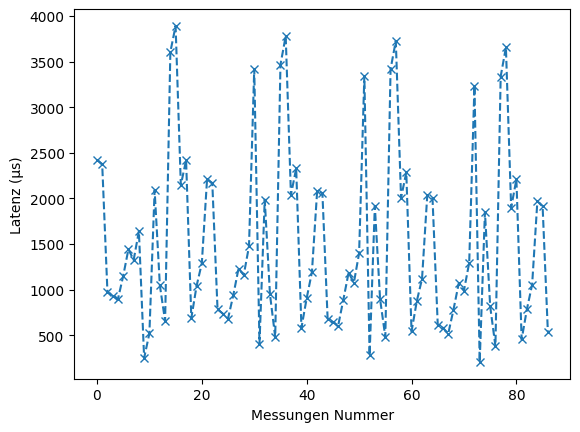


Durchschnittliche Latenz: 1510.250 μs
Minimale Latenz: 207.612 μs


In [29]:
analyse_experiment("measurements/test1.pcap", "measurements/entries_1.txt")

Processing PCAP: 149737it [00:25, 5795.64it/s]
Extracting timestamps: 100%|██████████| 304/304 [00:00<00:00, 1031608.75it/s]


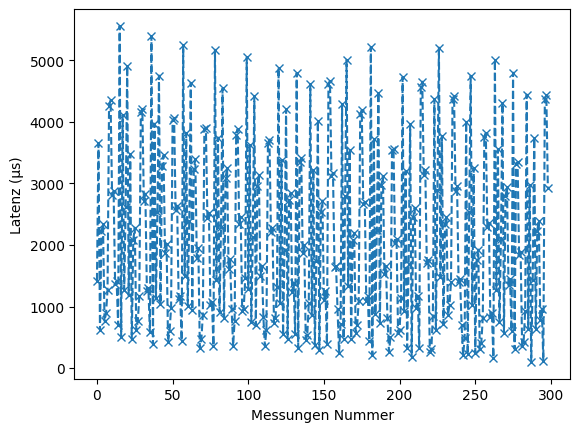


Durchschnittliche Latenz: 2121.268 μs
Minimale Latenz: 99.985 μs


In [30]:
analyse_experiment("measurements/test2.pcap", "measurements/entries_2.txt")

Processing PCAP: 0it [00:00, ?it/s]

Processing PCAP: 1347208it [03:52, 5789.80it/s]
Extracting timestamps: 100%|██████████| 30/30 [00:00<00:00, 387166.52it/s]


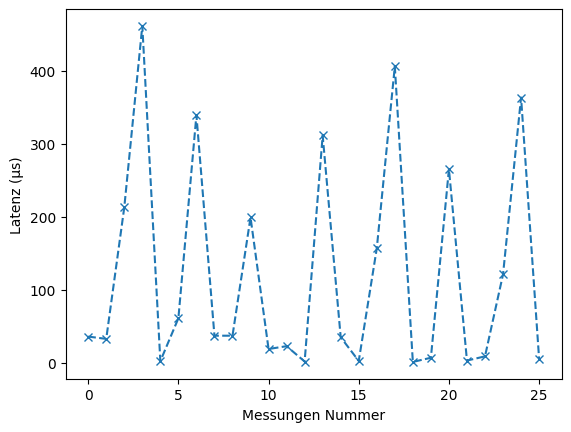


Durchschnittliche Latenz: 121.168 μs
Minimale Latenz: 1.098 μs


In [31]:
analyse_experiment("measurements/test4.pcap", "measurements/entries_4.txt")

Processing PCAP: 0it [00:00, ?it/s]

Processing PCAP: 457260it [01:19, 5739.44it/s]
Extracting timestamps: 100%|██████████| 91/91 [00:00<00:00, 693966.66it/s]


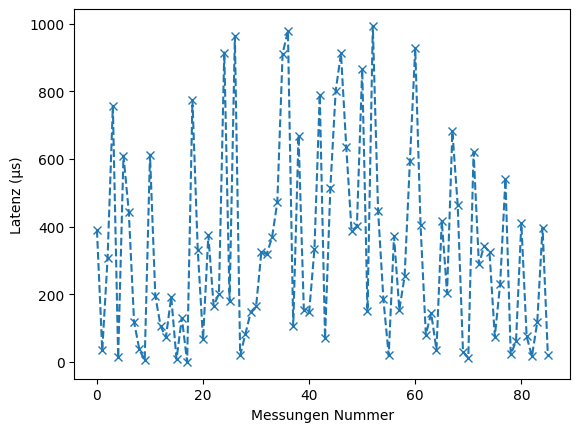


Durchschnittliche Latenz: 333.782 μs
Minimale Latenz: 0.055 μs


In [32]:
analyse_experiment("measurements/test5.pcap", "measurements/entries_5.txt")

Processing PCAP: 445797it [01:18, 5654.24it/s]
Extracting timestamps: 100%|██████████| 87/87 [00:00<00:00, 725456.16it/s]


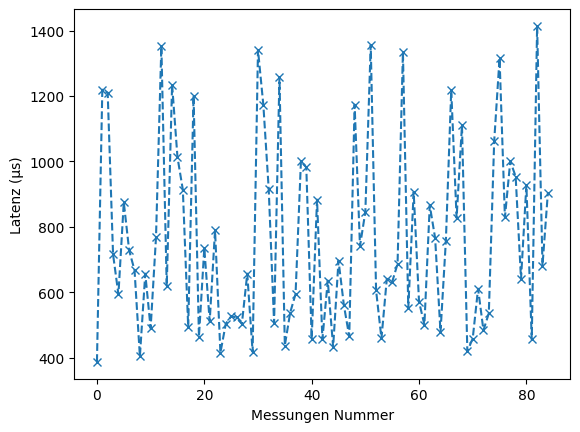


Durchschnittliche Latenz: 760.719 μs
Minimale Latenz: 387.479 μs


In [33]:
analyse_experiment("measurements/test6.pcap", "measurements/entries_6.txt")

Processing PCAP: 455576it [01:18, 5812.74it/s]
Extracting timestamps: 100%|██████████| 90/90 [00:00<00:00, 710898.98it/s]


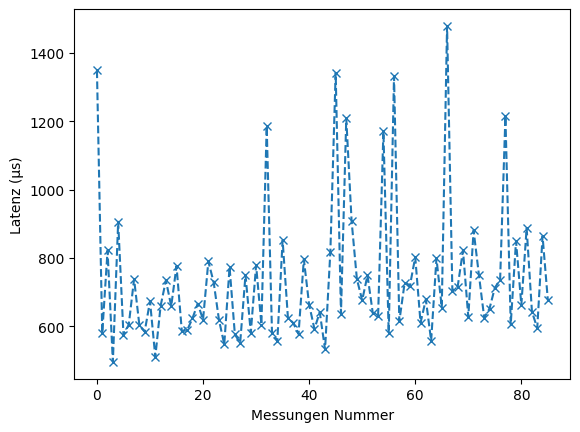


Durchschnittliche Latenz: 734.342 μs
Minimale Latenz: 495.565 μs


In [34]:
analyse_experiment("measurements/test7.pcap", "measurements/entries_7.txt")

Processing PCAP: 455820it [01:18, 5790.26it/s]
Extracting timestamps: 100%|██████████| 89/89 [00:00<00:00, 720642.97it/s]


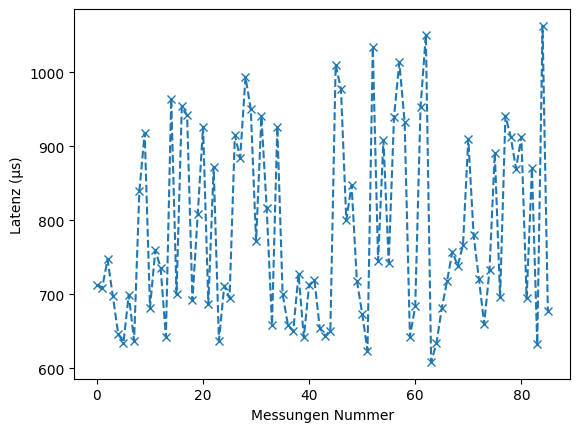


Durchschnittliche Latenz: 783.999 μs
Minimale Latenz: 608.570 μs


In [35]:
analyse_experiment("measurements/test8.pcap", "measurements/entries_8.txt")

Processing PCAP: 451913it [01:18, 5738.14it/s]
Extracting timestamps: 100%|██████████| 90/90 [00:00<00:00, 758006.75it/s]


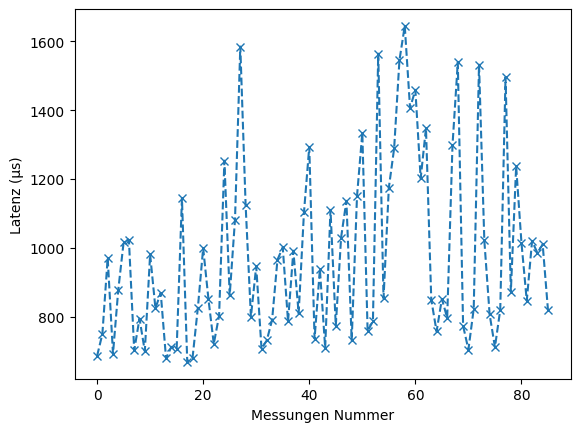


Durchschnittliche Latenz: 974.450 μs
Minimale Latenz: 669.060 μs


In [36]:
analyse_experiment("measurements/test9.pcap", "measurements/entries_9.txt")

Processing PCAP: 453745it [01:17, 5881.03it/s]
Extracting timestamps: 100%|██████████| 96/96 [00:00<00:00, 758292.25it/s]


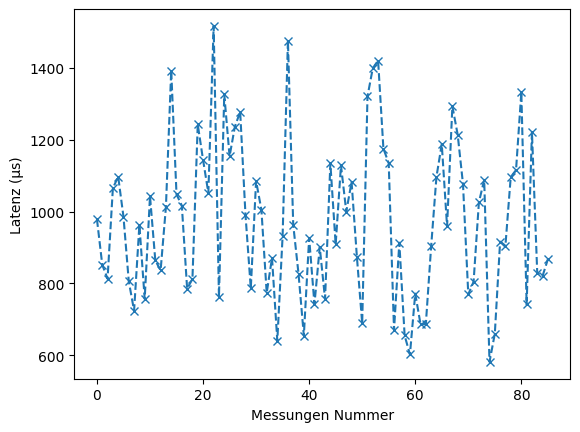


Durchschnittliche Latenz: 972.519 μs
Minimale Latenz: 581.377 μs


In [37]:
analyse_experiment("measurements/test10.pcap", "measurements/entries_10.txt")

Processing PCAP: 0it [00:00, ?it/s]

Processing PCAP: 457136it [01:18, 5836.99it/s]
Extracting timestamps: 100%|██████████| 899/899 [00:00<00:00, 1298890.56it/s]


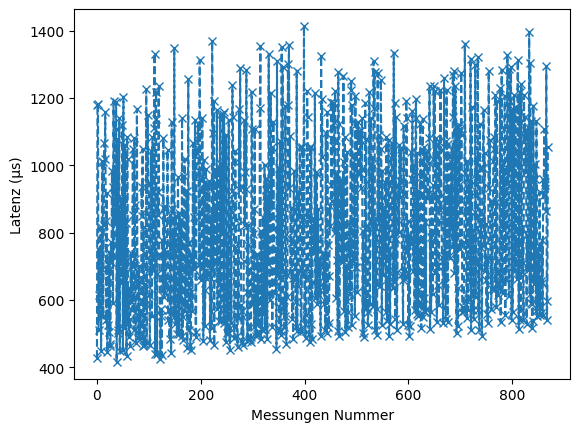


Durchschnittliche Latenz: 814.305 μs
Minimale Latenz: 415.798 μs


In [38]:
analyse_experiment("measurements/test11.pcap", "measurements/entries_11.txt")